### **`CIFAR IMAGE CLASSIFICATION`**


The CIFAR-10 (Canadian Institute For Advanced Research)  Dataset<br/>


<p align="center">
<img src="http://www.cs.nthu.edu.tw/~shwu/courses/ml/labs/11_NN_Regularization/fig-cifar-10.png"/>

CIFAR-10 consists of 60000 32x32 color images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. Here are the classes in the dataset, as well as 10 random images from each:

0: Airplane <br/>
1: Automobile <br/>
2: Bird <br/>
3: Cat <br/>
4: Deer <br/>
5: Dog <br/>
6: Frog <br/>
7: Horse <br/>
8: Ship <br/>
9: Truck 



In [1]:
## import tensorflow module

import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt

print(tf.__version__)

2.2.0


In [ ]:
!pip install h5py 

## **Load the data**

In [2]:
print("[INFO downloading CIFAR]")
(trainData , trainLabels) , (testData,testLabels) = tf.keras.datasets.cifar10.load_data()

[INFO downloading CIFAR]
170500096/170498071 [==============================] - 4s 0us/step


In [3]:
# Their might be chances that some of the image has been deprecated so it will throw as warning message
# which we have to ignore

from warnings import filterwarnings
filterwarnings('ignore')

In [5]:
## Parameter for CIFAR data set

image_width = 32
image_height = 32
image_channels = 3     # RGB image
num_classes = 10       # Output whould be range from 0-9 i.e. 10

In [6]:
## class name

class_name = ['Airplane','Automobile','Bird','Cat','Deer','Dog','Frog','Horse','Ship','Truck boot']

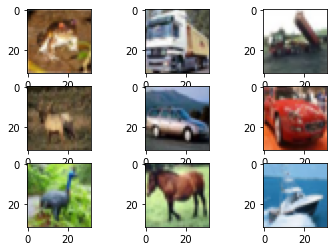

In [7]:
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# plot raw pixel data
	plt.imshow(trainData[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

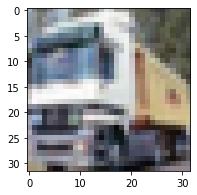

Maximum RGB value in this image 254
Minimum RGB value in this image 5


In [8]:
plt.figure(figsize = (5,3))
plt.imshow(trainData[1], cmap=plt.get_cmap('gray'))
plt.show()

print('Maximum RGB value in this image {}'.format(trainData[1].max()))
print('Minimum RGB value in this image {}'.format(trainData[1].min()))

In [9]:
print(trainData.shape)         # (no. of image , width , height)
print(testData.shape)
print(trainLabels.shape)
print(testLabels.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000, 1)
(10000, 1)


In [10]:
# Ravel convert shape (N,1) to shape (N,)

trainLabels = trainLabels.ravel()
testLabels = testLabels.ravel()

In [11]:
print(trainData.shape)         # (no. of image , width , height)
print(testData.shape)
print(trainLabels.shape)
print(testLabels.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000,)
(10000,)


In [12]:
print("Truck input image :" , trainData[1].shape)
print("Label corresponding to input image :",trainLabels[1])  # 9 represent Truck

Truck input image : (32, 32, 3)
Label corresponding to input image : 9


In [13]:
'''
As Dataset already in the form of channel last ordering , in most cases we don't have that like mnist dataset
'''
# Shape the input data based on the "Channel last" ordering 
# num_samples x rows x columns x depth (channel)

trainData = trainData.reshape(trainData.shape[0] ,image_height,image_width,image_channels)
testData = testData.reshape(testData.shape[0] ,image_height,image_width,image_channels)

In [14]:
print(trainData.shape)         # (no. of image , width , height, channel)
print(testData.shape)
print(trainLabels.shape)
print(testLabels.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000,)
(10000,)


In [15]:
# We normalize the image 
# we scale them between [0.0,1.0]

trainData = trainData.astype("float32") / 255.0 
testData = testData.astype("float32") / 255.0

In [16]:
print('Maximum RGB value in this image {}'.format(trainData[1].max()))
print('Minimum RGB value in this image {}'.format(trainData[1].min()))

Maximum RGB value in this image 0.9960784316062927
Minimum RGB value in this image 0.019607843831181526


##**Import package**

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,Dropout,BatchNormalization,AveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend

`Input Layer`: It represent input image data. It will reshape image into single diminsion array. Example your image is 64x64 = 4096, it will convert to (4096,1) array.

`Conv Layer`: This layer will extract features from image.

`Pooling Layer`: This layerreduce the spatial volume of input image after convolution.

`Fully Connected Layer`: It connect the network from a layer to another layer.

`Output Layer`: It is the predicted values layer.


The difference between 'SAME' and 'VALID' padding in tf.nn.max_pool of tensorflow is as follows:

**`"SAME"`**: 
Here the output size is the same as input size. This requires the filter window to slip outside input map, hence the need to pad.

**`"VALID"`** :
When you use valid the filter window stays at valid position inside input map, so output size shrinks by filter_size - 1. No padding occurs.


#### **Forms of regularization** 

1. Data augmentation
2. Dropout
3. Batch norm
4. Early stopping
5. use of L1 and L2 regularization (also known as "weight decay")
6. fine-tuning one more convolutional block (alongside greater regularization)

When we have pretty small dataset (~ 1000 samples), you would probably be safe using a batch size of 32, which is pretty standard. It won't make a huge difference for your problem unless you're training on hundreds of thousands or millions of observations.

In general: Larger batch sizes result in faster progress in training, but don't always converge as fast. Smaller batch sizes train slower, but can converge faster. It's definitely problem dependent.

In general, the models improve with more epochs of training, to a point. They'll start to plateau in accuracy as they converge. Try something like 50 and plot number of epochs (x axis) vs. accuracy (y axis). You'll see where it levels out.

In [66]:
# Define the model as a class
class CIFAR:

  ''' In a sequential model, we stack layers sequentially. 
      So, each layer has unique input and output, and those inputs and outputs 
      then also come with a unique input shape and output shape.
  '''
  # 3 Convolutional unit (conv,activation,pooling)
  # INPUT => CONV => Relu => AVG-POOL => CONV => Relu => AVG-POOL => FC => Relu => FC => Relu => FC => SOFTMAX
  
  @staticmethod                ## class can instantiated only once 
  def init(numChannels, imgRows, imgCols , numClasses, weightsPath=None):
    
    # if we are using channel first we have update the input size
    if backend.image_data_format() == "channels_first":
      inputShape = (numChannels , imgRows , imgCols)
    else: 
      inputShape = (imgRows , imgCols , numChannels)
    
    # initilize the model
    model = Sequential()

    # Define the first set of CONV => ACTIVATION => POOL LAYERS
    model.add(Conv2D(  filters=16,kernel_size=(3,3),strides=(1,1), 
                              padding="valid",activation='relu',kernel_initializer='he_uniform',input_shape=inputShape))
    model.add(AveragePooling2D(pool_size=(2,2),strides=(2,2)))


    # Define the second set of CONV => ACTIVATION => POOL LAYERS
    model.add(Conv2D(  filters=32,kernel_size=(3,3),strides=(1,1), 
                              padding="valid",activation='relu',kernel_initializer='he_uniform'))
    model.add(AveragePooling2D(pool_size=(2,2),strides=(2,2)))

    # Define the second set of CONV => ACTIVATION => POOL LAYERS
    model.add(Conv2D(  filters=64,kernel_size=(3,3),strides=(1,1), 
                              padding="valid",activation='relu',kernel_initializer='he_uniform'))
    model.add(AveragePooling2D(pool_size=(2,2),strides=(2,2)))

    # Flatten the convolution volume to fully connected layers (convert them into single vector)

    model.add(Flatten())

    # Define the first FC layer + Activation 

    model.add(Dense(units=120, activation='relu',kernel_initializer='he_uniform'))

    # Define the second FC layer + Activation 

    model.add(Dense(units=84, activation='relu',kernel_initializer='he_uniform'))

    # lastly , define the softmax classifier

    model.add(Dense(units=numClasses,activation='softmax'))

    # if a weights path is supplied (indicating that the model was pre-trained)
    # then add weights

    if weightsPath is not None:
      model.load_weights(weightsPath)
    
    # return the constructed network architecture
    return model

    '''
      NOTE :  Instead adding each layer step by step we can also do 

              model = tf.keras.sequantial([
                          tf.keras.conv2d(.....)
                          tf.keras.averagepooling2d(.....)
                          tf.keras.layers.flatten(.....)
                          tf.keras.layers.dense(.....)
                      ])
              Add layers in the array
    '''

In [67]:
print("[INFO] Compiling model ... ")
model = CIFAR.init(numChannels=image_channels,
                    imgRows=image_width,
                    imgCols=image_height,
                    numClasses=num_classes,
                    weightsPath=None                      
                   )

# Compile the model 
# Specify the training configuration (optimizer, loss, metrics)

model.compile(
              optimizer=tf.keras.optimizers.Adam(  
                                                      learning_rate=0.01,   
                                                        beta_1=0.9,
                                                        beta_2=0.999,
                                                        epsilon=1e-07,
                                                        amsgrad=False,
                                                        name="Adam"
                                                    ),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy']
            )

# Print model summery
model.summary()

[INFO] Compiling model ... 
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 30, 30, 16)        448       
_________________________________________________________________
average_pooling2d_18 (Averag (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 13, 13, 32)        4640      
_________________________________________________________________
average_pooling2d_19 (Averag (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 4, 4, 64)          18496     
_________________________________________________________________
average_pooling2d_20 (Averag (None, 2, 2, 64)          0         
_________________________________________________________________
flatten_4 (Flatten)      

## **`Callbacks`**


In [68]:
# Package
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint

### **`Early stopping`**

In [69]:
'''
Early Stop

To prevent over fitting we will stop the learning after 7 epochs and if val_loss value not decreased
'''
earlystop = EarlyStopping(monitor='val_loss',patience=7)


### **`Learning Rate Reduction`**

We will reduce the learning rate when then accuracy not increase for 3 steps

In [70]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=4, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001
                                            ) 

### **`Checkpoint`**

In [71]:
filepath="cifar_classification_checkpoint_weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [72]:
callbacks = [earlystop,learning_rate_reduction,checkpoint] 

##**Train Model**

In [73]:
# initilize training config 
batch_size = 128
epochs = 100

# Run training
print("[INFO] Training ...")

history = model.fit(x=trainData , y=trainLabels , validation_data=(testData,testLabels),
                    batch_size=batch_size,epochs=epochs,
                    verbose=1,callbacks=callbacks)
# save model
'''
  Save Final Model
  A final model is typically fit on all available data, such as the combination of all train and test dataset.

  Note: saving and loading a Keras model requires that the h5py library is installed on your workstation.

  The h5py package is a Pythonic interface to the HDF5 binary data format.
  It lets you store huge amounts of numerical data, and easily manipulate that data from NumPy.

'''
model.save('CIFAR_Dataset_Model.h5')



[INFO] Training ...
Epoch 1/100
391/391 [==============================] - ETA: 0s - loss: 1.7000 - accuracy: 0.3657
Epoch 00001: val_accuracy improved from -inf to 0.45410, saving model to cifar_classification_checkpoint_weights.best.hdf5
391/391 [==============================] - 34s 87ms/step - loss: 1.7000 - accuracy: 0.3657 - val_loss: 1.4681 - val_accuracy: 0.4541 - lr: 0.0100
Epoch 2/100
391/391 [==============================] - ETA: 0s - loss: 1.4158 - accuracy: 0.4823
Epoch 00002: val_accuracy improved from 0.45410 to 0.51170, saving model to cifar_classification_checkpoint_weights.best.hdf5
391/391 [==============================] - 33s 86ms/step - loss: 1.4158 - accuracy: 0.4823 - val_loss: 1.3612 - val_accuracy: 0.5117 - lr: 0.0100
Epoch 3/100
391/391 [==============================] - ETA: 0s - loss: 1.3011 - accuracy: 0.5320
Epoch 00003: val_accuracy improved from 0.51170 to 0.53950, saving model to cifar_classification_checkpoint_weights.best.hdf5
391/391 [=============

In [75]:
print('\nhistory dict:', history.history.keys())


history dict: dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


##**Visualization**

In [76]:
%matplotlib inline
import matplotlib.pyplot as plt

# retrieve a list of list results on training and test data sets for each training epoch
acc = history.history['accuracy']                         
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))        ## get number of epochs

##**Plot training and validation accuracy per epoch**

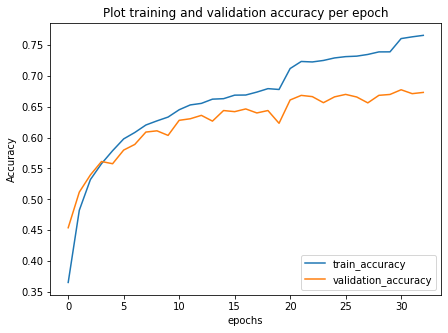

In [77]:
plt.figure(figsize=(7,5))
plt.plot(epochs, acc,label='train_accuracy')
plt.plot(epochs, val_acc,label='validation_accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend(loc="lower right")
plt.title('Plot training and validation accuracy per epoch')
plt.show()


##**Plot training and validation loss per epoch**


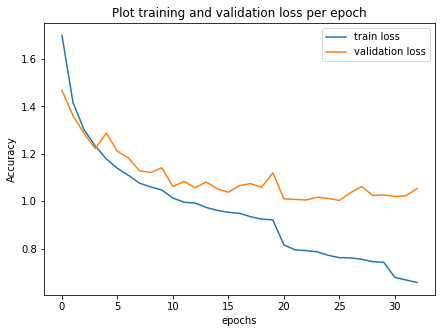

In [78]:
plt.figure(figsize=(7,5))
plt.plot(epochs, loss,label='train loss')
plt.plot(epochs, val_loss,label='validation loss')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend(loc="upper right")
plt.title('Plot training and validation loss per epoch')
plt.show()

##**Show accuracy on the testing data**

In [79]:
'''
The evaluate_model() function below implements these behaviors,
taking the training dataset as arguments and returning a list of
accuracy scores and training histories that can be later summarized.

'''
print("[INFO] Evaluating ... ")
(loss,accuracy) = model.evaluate(testData,testLabels,batch_size=batch_size,verbose=1)
print("[INFO] accuracy : {:.2f}%".format(accuracy*100))

[INFO] Evaluating ... 
79/79 [==============================] - 2s 31ms/step - loss: 1.0537 - accuracy: 0.6729
[INFO] accuracy : 67.29%


In [80]:
## Save the weight

'''
Here we are storing both model and weights
'''

model.save_weights("weights/CIFAR_Dataset.temp.hd5",overwrite=True)


##**Evaluate pre-trained model**

In [81]:
'''
from keras.model import load_model doesn't work for me 
Hence i used  -> tf.keras.models.load_model

Check this : https://stackoverflow.com/questions/53183865/unknown-initializer-glorotuniform-when-loading-keras-model
'''

print("[INFO] Compiling model ... ")
model =  tf.keras.models.load_model('CIFAR_Dataset_Model.h5')

[INFO] Compiling model ... 


In [82]:
'''
As we are using pre-trained model we don't have to re-train the model
we are not writing the whole architecture again  
'''

print("[INFO] Evaluating ... ")
(loss,accuracy) = model.evaluate(testData,testLabels,batch_size=batch_size,verbose=1)
print("[INFO] accuracy : {:.2f}%".format(accuracy*100))

[INFO] Evaluating ... 
79/79 [==============================] - 2s 31ms/step - loss: 1.0537 - accuracy: 0.6729
[INFO] accuracy : 67.29%


##**Model predictions**

In [83]:
# import package -> OpenCV
import cv2               # cv : computer vision libray

In [84]:
# set up matplotlib fig and size it to fit 3 rows and 4 col

nrows = 3
ncols = 4
'''
matplotlib.pyplot.gcf() is primarily used to get the current figure.
If no current figure is available then one is created with the help of the figure() function

'''
fig = plt.gcf()
fig.set_size_inches(ncols*6 , nrows*6)

<Figure size 1728x1296 with 0 Axes>

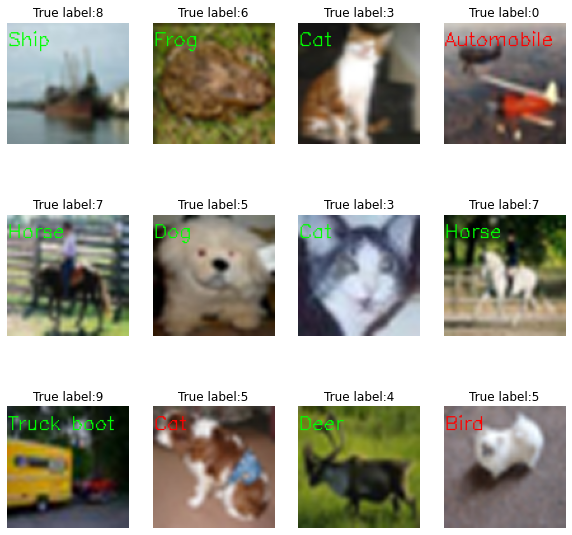

In [86]:
# Randomly select a few testing image
plt.figure(figsize=(10,10))
num_prediction = 12

'''
Generate a uniform random sample from np.arange(5) of size 3:

>>> np.random.choice(5, 3)
array([0, 3, 4])
>>> #This is equivalent to np.random.randint(0,5,3)

'''
# index of selected random image from test dataset
test_indices = np.random.choice(np.arange(0, len(testLabels)),size=(num_prediction,))     

# Get the testing image using list comprehension
test_images = np.stack(([ testData[i] for i in test_indices ]))

# Get the testing image labels using list comprehension
test_labels = np.stack(([ testLabels[i] for i in test_indices ])) 

# Compute_prediction
predictions = model.predict(test_images)

for i in range(num_prediction):

  '''
  As output would be in the form of probability as we are using softmax function
  at output layer , so we are choosing the class which have highest probability
  '''
  prediction = np.argmax(predictions[i])

  # rescale the test image 
  # As it was normailize between 0 to 1 
  image = (test_images[i]*255).astype("uint8") 

  # resize the image from a 32x32 images into 96x96 so that can see the image clearly
  image = cv2.resize(image, (96,96), interpolation=cv2.INTER_CUBIC)

  # convert grayscale into rgb color , 3 represent -: 3 channels
  #image = cv2.merge([image]*3)

  # if prediction == ground truth label then mark with green else with red
  if prediction == test_labels[i]:
    rgb_color = (0,255,0)       ## true prediction
  else:
    rgb_color = (255,0,0)       ## False prediction

  # put text on the image
  cv2.putText(image, str(class_name[prediction]),(0,18), cv2.FONT_HERSHEY_SIMPLEX,0.50,rgb_color,1)

  # set up subplot ; subplot indices starts from 1
  sp = plt.subplot(nrows,ncols,i+1,title="True label:%s"% test_labels[i])
  sp.axis('Off')      # Don't show axis
  plt.imshow(image)

plt.show()  

### **Test on sample image**

#### **Test Image : Deer** <br/>
  <p align="center"/>
  <img src="https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/02/sample_image-1-300x298.png" alt="sample-image" border="0" width="30%">
  </p>

Reference : [https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/](https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/)

In [95]:
# make a prediction for a new image.
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array


# load and prepare the image
def load_image(filename):
	# load the image
	img = load_img(filename, target_size=(32, 32))
	# convert to array
	img = img_to_array(img)
	# reshape into a single sample with 1 channel
	img = img.reshape(1, 32, 32, 3)
	# prepare pixel data
	img = img.astype('float32')
	img = img / 255.0
	return img

# load an image and predict the class
def run_example():
	# load the image
	img = load_image('sample_image.png')
	# load model
	model = tf.keras.models.load_model('CIFAR_Dataset_Model.h5')
	# predict the class
	result = model.predict_classes(img)
	print(result[0])



In [96]:
'''
 Here 5 means Deer , Hence Our model succesfully predicted the class or label
'''
run_example()

5


Reference :

1.  [Shala2020 Website](shala2020.github.io/)
2.  [DLV-1-CNNs for Image Classification](https://www.youtube.com/watch?v=ucV1TbhoueM&t=2428s)
3.[machinelearningmastery- save-load-keras-deep-learning-models](https://machinelearningmastery.com/save-load-keras-deep-learning-models/#:~:text=Save%20Your%20Neural%20Network%20Model%20to%20JSON&text=This%20can%20be%20saved%20to,the%20symmetrical%20load_weights()%20function.)